# L41: Lab 2 - Inter-Process Communication (IPC) and TCP/IP

This notebook provides an initial data collection framework for the `ipc-benchmark` benchmark used in Lab 2 for a range of IPC and TCP/IP analysis tasks.

## Reference material
Here are some useful sources of information as you dig into this lab:

- [Raspberry Pi 4 - Broadcom 2711 (BCM2711)](https://www.raspberrypi.org/documentation/hardware/raspberrypi/bcm2711/README.md)
- [ARM® Cortex®-A72 MPCore Processor - see section 11.8](https://developer.arm.com/documentation/100095/0003)
- [Arm Architecture Reference Manual Armv8, for Armv8-A architecture profile - see sections D7.11.3 and Appendix K3](https://developer.arm.com/documentation/ddi0487/latest/)

# `ipc-benchmark` benchmark usage information

In [4]:
!ipc/ipc-benchmark

ipc-benchmark.o [-Bjqsv] [-b buffersize] [-i pipe|local|tcp] [-n iterations]
    [-p tcp_port] [-P arch|dcache|instr|tlbmem] [-t totalsize] mode

Modes (pick one - default 1thread):
    1thread                IPC within a single thread
    2thread                IPC between two threads in one process
    2proc                  IPC between two threads in two different processes

Optional flags:
    -B                     Run in bare mode: no preparatory activities
    -i pipe|local|tcp      Select pipe, local sockets, or TCP (default: pipe)
    -j                     Output as JSON
    -p tcp_port            Set TCP port number (default: 10141)
    -P arch|dcache|instr|tlbmem  Enable hardware performance counters
    -q                     Just run the benchmark, don't print stuff out
    -s                     Set send/receive socket-buffer sizes to buffersize
    -v                     Provide a verbose benchmark description
    -b buffersize          Specify the buffer size (default:

## Collect IPC performance data
We run the benchmark multiple times (dropping the first sample as the benchmark "settles"), across a range of buffer sizes, and capture the results as JSON. The resulting associative array of output strings, `benchmark_output` is indexed by buffer size, with each array entry containing a JSON blob for that run of the benchmark.

In [11]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats

# Number of iterations to run in each configuration; first will be dropped. Set low for experimentation; consider using 11 "in production"
iterations=3

# Log(2) of the maximum buffer size to use
logmaxbufsize=25   # 16M default
#logmaxbufsize=20   # 512K
#logmaxbufsize=14   # 8K
#logmaxbufsize=4

# Total data to transit over IPC or TCP/IP
#totalsize=16777216
totalsize=1<<(logmaxbufsize-1)

# The list of buffer sizes to iterate over when doing data processing, plotting, etc.
buffersizes = [2**v for v in range(logmaxbufsize)]

# XXXRW: Make sure to remove -B
benchmark_output = {}
print("Running IPC benchmark with", iterations, "iterations for each block size; this will take several minutes")
for buffersize in buffersizes:
    print("  Running set with buffersize", buffersize);
    output = !ipc/ipc-benchmark -i pipe -B -t $totalsize -b $buffersize -j -P dcache -n $iterations -g -v 2thread
    benchmark_output[buffersize] = ' '.join(output)
print("Done.")

Running IPC benchmark with 3 iterations for each block size; this will take several minutes
  Running set with buffersize 1
  Running set with buffersize 2
  Running set with buffersize 4
  Running set with buffersize 8
  Running set with buffersize 16
  Running set with buffersize 32
  Running set with buffersize 64
  Running set with buffersize 128
  Running set with buffersize 256
  Running set with buffersize 512
  Running set with buffersize 1024
  Running set with buffersize 2048
  Running set with buffersize 4096
  Running set with buffersize 8192
  Running set with buffersize 16384
  Running set with buffersize 32768
  Running set with buffersize 65536
  Running set with buffersize 131072
  Running set with buffersize 262144
  Running set with buffersize 524288
  Running set with buffersize 1048576
  Running set with buffersize 2097152
  Running set with buffersize 4194304
  Running set with buffersize 8388608
  Running set with buffersize 16777216
Done.


# Generate summary statistics for plotting
We construct a set of arrays of summary statistics, indexed by block size

In [12]:
# Parse the JSON for each sample so that we can determine what metrics to plot
# We will at least receive bandwidth and time, but may also get performance
# counter data to be plotted on the same blocksize x axis.  The resulting dict
# 'benchmark_samples' is indexed by block size.
benchmark_samples = {}
for buffersize in buffersizes:
    j = json.loads(benchmark_output[buffersize])
    benchmark_samples[buffersize] = list(j["benchmark_samples"])
    
# Extract primary measurement: bandwidth
bw_samples = {}          # Array of bandwidth samples indexed by buffer size
bw_medians = {}          # Array of medians indexed by buffer size
bw_stds = {}             # Array of standard deviations indexed by buffer size
bw_uppererr = {}         # Array of Q3-median indexed by buffer size
bw_lowererr = {}         # Array of median-Q1 indexed by buffer size

for buffersize in buffersizes:
    bw_samples[buffersize] = list([x["bandwidth"] for x in benchmark_samples[buffersize]])
    bw_medians[buffersize] = stats.median(bw_samples[buffersize])
    bw_stds[buffersize] = stats.stdev(bw_samples[buffersize])
    bw_lowererr[buffersize] = bw_medians[buffersize] - np.quantile(bw_samples[buffersize], 0.25)
    bw_uppererr[buffersize] = np.quantile(bw_samples[buffersize], 0.75) - bw_medians[buffersize]

# Generate summary statistics for directly measured data -- each hash table
# is indexed first by metric, and then buffer size.
metric_list = list(benchmark_samples[buffersizes[0]][0].keys())
#metric_list.remove("bandwidth")
#metric_list.remove("time")

print("Metrics found", metric_list)

metric_samples = {}
metric_medians = {}
metric_stds = {}
metric_lowererr = {}
metric_uppererr = {}
for metric in metric_list:
    metric_samples[metric] = {}
    metric_medians[metric] = {}
    metric_stds[metric] = {}
    metric_lowererr[metric] = {}
    metric_uppererr[metric] = {}
    for buffersize in buffersizes:
        s = list([float(x[metric]) for x in benchmark_samples[buffersize]])
        metric_samples[metric][buffersize] = s
        metric_medians[metric][buffersize] = stats.median(s)
        metric_stds[metric][buffersize] = stats.stdev(s)
        metric_lowererr[metric][buffersize] = metric_medians[metric][buffersize] - np.quantile(s, 0.25)
        metric_uppererr[metric][buffersize] = np.quantile(s, 0.75) - metric_medians[metric][buffersize]

Metrics found ['bandwidth', 'time', 'INST_RETIRED', 'CPU_CYCLES', 'L1D_CACHE', 'L1D_CACHE_REFILL', 'L2D_CACHE', 'L2D_CACHE_REFILL', 'CYCLES_PER_INSTRUCTION', 'L1D_CACHE_HIT_RATE', 'L2D_CACHE_HIT_RATE', 'utime', 'stime', 'msgsnd', 'msgrcv']


## Plot resulting data

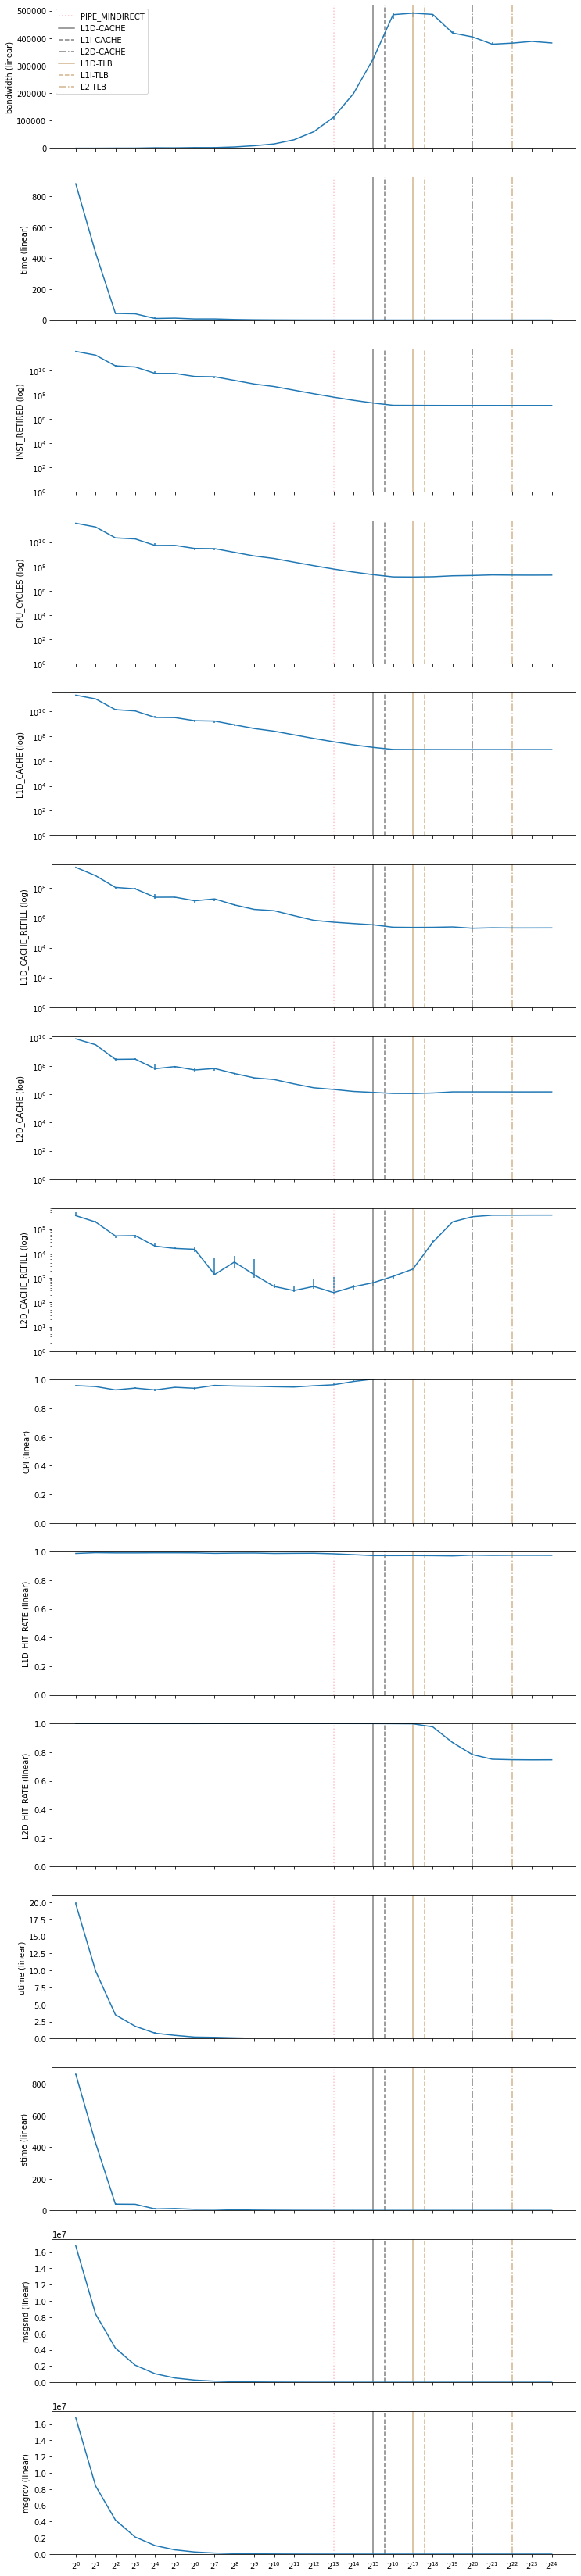

In [13]:
fig, axes = plt.subplots(len(metric_list), 1, sharex=True)
fig.set_size_inches(12, 4 * len(metric_list))

# X axis shared by all plots
x_coords = buffersizes

ax_num = 0
for metric in metric_list:
    
    # Prepare this specific data set -- derive summary statistics, etc.
    y_coords = []
    errbars = []
    lower_errbar = []
    upper_errbar = []
    for x in buffersizes:
        y_coords.append(metric_medians[metric][x])
        errbars.append(metric_stds[metric][x])
        lower_errbar.append(metric_lowererr[metric][x])
        upper_errbar.append(metric_uppererr[metric][x])        

    ax = axes[ax_num]
    ax.errorbar(x_coords, y_coords, [lower_errbar, upper_errbar])
    
    # Logarithmic X axis as we sample at powers of 2.  Care required,
    # as it can be visually misleading.  Put ticks are those powers of
    # 2 to remind the reader.
    ax.set_xscale("log", base=2)
    ax.set_xticks(buffersizes)

    # Do a bit of rewriting to make axis labels more readable.
    if (metric == "L2D_CACHE_HIT_RATE"):
        label = "L2D_HIT_RATE"
    elif (metric == "L1D_CACHE_HIT_RATE"):
        label = "L1D_HIT_RATE"
    elif (metric == "CYCLES_PER_INSTRUCTION"):
        label = "CPI"
    else:
        label = metric

    # Select y axis properties based on the kind of metric it is.
    if ("RATE" in metric or "PER" in metric or "time" in metric or "msg" in metric or "bandwidth" in metric):
        label = label + " (linear)"
        ax.set_yscale("linear")
        ax.set_ylim(ymin=0)
    else:
        label = label + " (log)"
        ax.set_yscale("log")
        ax.set_ylim(ymin=1)
    if ("RATE" in metric or "PER" in metric):
        ax.set_ylim(ymax=1)
        
    ax.set_ylabel(label)
    
    #if (ax_num != 0):
    #    ax.label_outer()
        
    # Draw some vertical lines at key hardware and software thresholds.
    # In some cases, they will fall between samples.
    ax.axvline(x=8*1024, color="pink", label="PIPE_MINDIRECT", linestyle=":")
    
    ax.axvline(x=32*1024, color="grey", label="L1D-CACHE", linestyle="-")
    ax.axvline(x=48*1024, color="grey", label="L1I-CACHE", linestyle="--")
    ax.axvline(x=1024*1024, color="grey", label="L2D-CACHE", linestyle="-.")
    
    ax.axvline(x=32*4096, color="tan", label="L1D-TLB", linestyle="-")
    ax.axvline(x=48*4096, color="tan", label="L1I-TLB", linestyle="--")
    ax.axvline(x=1024*4096, color="tan", label="L2-TLB", linestyle="-.")
    
    if (ax_num == 0):
        ax.legend()

    ax_num += 1